In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [3]:
def load_image(path):
    byte_img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(byte_img)
    return img

In [4]:
train_images = tf.data.Dataset.list_files('augdata\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
train_images.as_numpy_iterator().next()

array([[[0.8029412 , 0.80784315, 0.45      ],
        [0.7882353 , 0.79607844, 0.43823528],
        [0.7823529 , 0.7921569 , 0.43333334],
        ...,
        [0.61470586, 0.7656863 , 0.28627452],
        [0.61470586, 0.7656863 , 0.28627452],
        [0.6186274 , 0.76960784, 0.2901961 ]],

       [[0.7254902 , 0.7823529 , 0.39215687],
        [0.6872549 , 0.7509804 , 0.35882354],
        [0.68333334, 0.7490196 , 0.35686275],
        ...,
        [0.5862745 , 0.7490196 , 0.26960784],
        [0.5862745 , 0.7490196 , 0.26960784],
        [0.5901961 , 0.7529412 , 0.2735294 ]],

       [[0.59313726, 0.722549  , 0.28137255],
        [0.5872549 , 0.71666664, 0.2754902 ],
        [0.5735294 , 0.7029412 , 0.2617647 ],
        ...,
        [0.5745098 , 0.75490195, 0.27745098],
        [0.5745098 , 0.75490195, 0.27745098],
        [0.5803922 , 0.7607843 , 0.28333333]],

       ...,

       [[0.7382353 , 0.5617647 , 0.07941177],
        [0.71862745, 0.57058823, 0.08333334],
        [0.64215684, 0

In [6]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [7]:
train_labels = tf.data.Dataset.list_files('augdata\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.7266, 0.3953, 0.769 , 0.4478], dtype=float16))

In [8]:
len(train_images), len(train_labels)

(1620, 1620)

In [9]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5996 , 0.4182 , 0.648  , 0.4727 ],
        [0.785  , 0.4346 , 0.833  , 0.4912 ],
        [0.8267 , 0.1368 , 0.8726 , 0.1935 ],
        [0.6523 , 0.06915, 0.6895 , 0.116  ],
        [0.397  , 0.621  , 0.4426 , 0.6714 ],
        [0.278  , 0.5415 , 0.3174 , 0.5903 ],
        [0.7656 , 0.06696, 0.8115 , 0.1215 ],
        [0.6826 , 0.5415 , 0.722  , 0.5903 ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


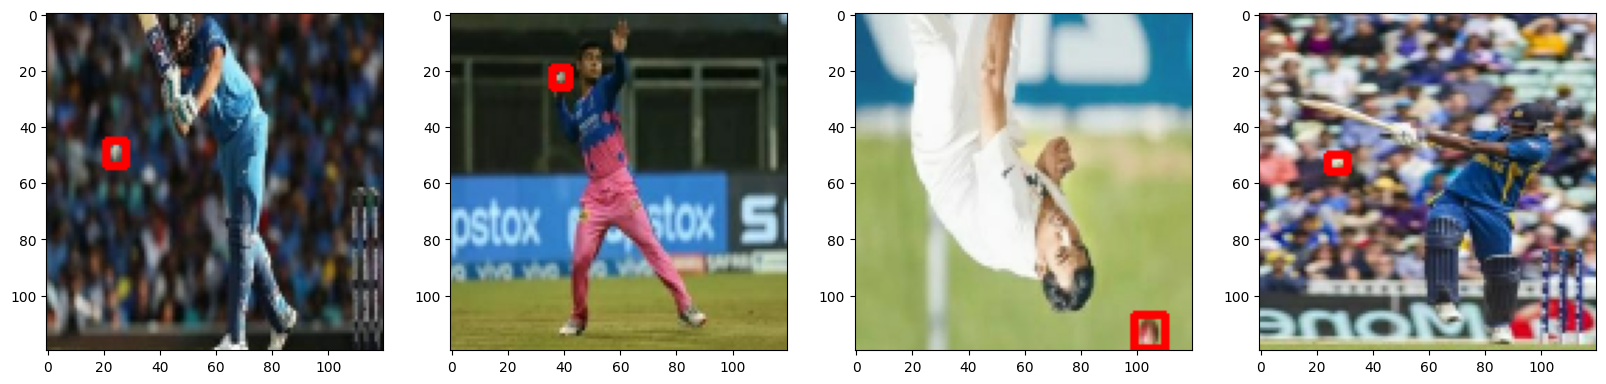

In [10]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [12]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    balltracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return balltracker

In [14]:
balltracker = build_model()
balltracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = balltracker.predict(X)
classes, coords

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

(array([[0.6796778 ],
        [0.7405945 ],
        [0.66067725],
        [0.7129848 ],
        [0.7515212 ],
        [0.6588056 ],
        [0.6853336 ],
        [0.6538889 ]], dtype=float32),
 array([[0.261199  , 0.48123384, 0.4055784 , 0.5377853 ],
        [0.28868884, 0.46653396, 0.5292732 , 0.6519558 ],
        [0.31991458, 0.44748792, 0.5149649 , 0.5535931 ],
        [0.17750455, 0.3592838 , 0.4226268 , 0.7082048 ],
        [0.2080305 , 0.503438  , 0.39552197, 0.6459897 ],
        [0.3866178 , 0.41968188, 0.46034926, 0.6563393 ],
        [0.27666822, 0.42546716, 0.47638142, 0.64088655],
        [0.19053373, 0.43383402, 0.46812484, 0.66254574]], dtype=float32))

In [15]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [16]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [17]:
localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.256617>

In [18]:
class Balltracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
model =Balltracker(balltracker)
model.compile(opt, classloss, regressloss)

In [23]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
203/203 [==============================] - 666s 3s/step - total_loss: 0.0588 - class_loss: 1.1121e-05 - regress_loss: 0.0588
Epoch 2/5
203/203 [==============================] - 3537s 17s/step - total_loss: 0.0057 - class_loss: 7.6189e-06 - regress_loss: 0.0057
Epoch 3/5
203/203 [==============================] - 645s 3s/step - total_loss: 0.0024 - class_loss: 3.3210e-06 - regress_loss: 0.0024
Epoch 4/5
203/203 [==============================] - 834s 4s/step - total_loss: 0.0019 - class_loss: 1.8346e-06 - regress_loss: 0.0019
Epoch 5/5
203/203 [==============================] - 857s 4s/step - total_loss: 0.0015 - class_loss: 1.1689e-06 - regress_loss: 0.0015


1/1 [==============================] - 1s 894ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


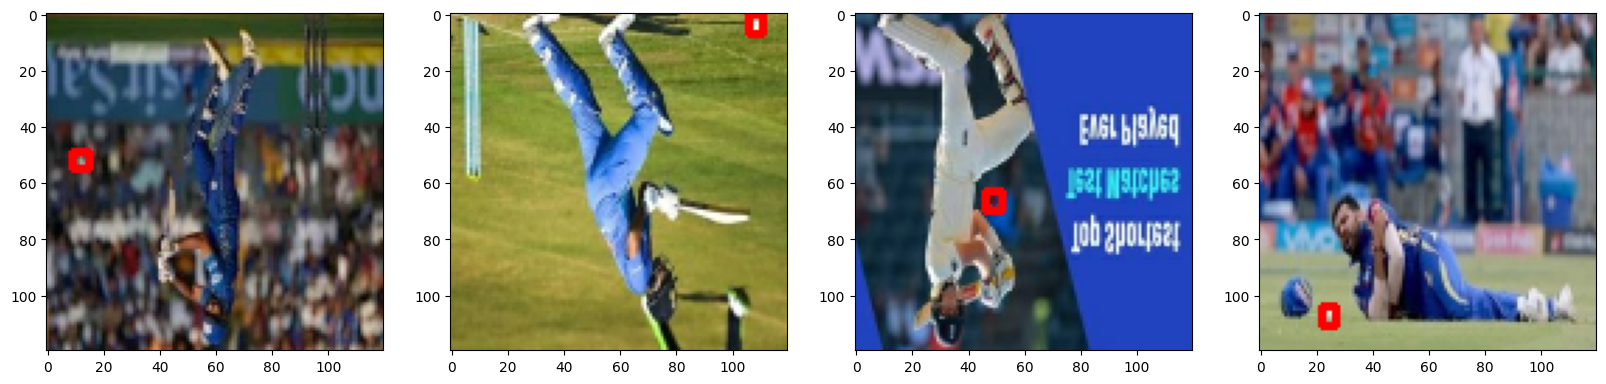

In [26]:
test_data = train.as_numpy_iterator()
test_sample = test_data.next()
yhat = balltracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
yhat
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [25]:
from tensorflow.keras.models import load_model
balltracker.save('ball-detection.h5')